## Worldwide Happiness Survey Data  

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn.model_selection import cross_validate,KFold
import geopandas as gpd
%matplotlib inline
color = sns.color_palette()
sns.set(style="white", palette="muted", color_codes=True)
pd.set_option('display.max_columns', 120)
pd.options.mode.chained_assignment = None  # default='warn'

## Method funtions

In [3]:
def cleanData(df):
    print ('------------------------------------------------------------------')
    print ('Removing errant and missing survey responses...')
    # delete row from array if values are missing/inaccurate in the survey
    # column numbers are referenced from features list below
    for col in df.columns:
        raw_temp = df[df[col] > 0]
        df = raw_temp
    df_clean = df
    print ('...There are now {} rows of data remaining.'.format(len(df_clean)))
    return df_clean

def splitData(df):
    print ('------------------------------------------------------------------')
    print ('Splitting data into test and train sets...')
    kf = KFold(n_splits=5,shuffle=True, random_state=None)
    for train_index, test_index in kf.split(df):
        dftrain, dftest = df.iloc[train_index], df.iloc[test_index]
    print ('...There are {} rows of {} data.'.format(dftrain.shape[0], 'train'))
    print ('...There are {} rows of {} data.'.format(dftest.shape[0], 'test'))
    return dftrain, dftest

def featuresTarget(tr,te):
    print ('------------------------------------------------------------------')
    print ('Separating the features and target...')
    ## This is a list of the important features to extract from raw data
    target_col = 'happiness'
    feature_cols = list(df_happiness_corr['desc'])
    feature_cols.append('ECONOMY')
    feature_cols.append("INCOME_GRP")
    target_train = tr[target_col]
    target_test = te[target_col]
    features_train = tr[feature_cols]
    features_test = te[feature_cols]
    return features_train, features_test, target_train, target_test

def createModel(type='nn'):
    print ('------------------------------------------------------------------')
    print ('Training a predictive model...')
    if type == 'rf':
        model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
    elif type == 'dt':
        model =  DecisionTreeClassifier(min_samples_split=20, random_state=99)
    elif type == 'nn':
        model = KNeighborsClassifier(n_neighbors=10)
    else:
        print ('Error: No model type selected!')
        sys.exit()
    clf = model.fit(feat_tr.values, tar_tr.values)
    return clf

def makePredictions(clf, testfeatures):
    print ('------------------------------------------------------------------')
    print ('Making predictions...')
    predictions = clf.predict(testfeatures)    
    return predictions

def getCV(preds, testtarget):
    print ('------------------------------------------------------------------')
    print ('Cross-validating the predictions with training data targets...')
    cv = []
    correct = 0
    for row in range(len(preds)):
        cv.append((((preds[row]) - testtarget[row])**2)**0.5)
        if preds[row] == testtarget[row]:
            correct += 1
    cv_score = (100-round(np.mean(cv)*100/np.mean(testtarget)))/100
    accuracy_score = round(correct*100/len(preds),2)
    # print 'When using the {} algorithm:'.format(algorithm_dict[algorithm])
    print ('The RMSE is {}.'.format(cv_score))
    print ('The prediction accuracy is {}%.'.format(accuracy_score))
    return accuracy_score, cv_score

def groupCountries(df):
    print ('------------------------------------------------------------------')
    print ('Grouping surveys into country groups...')
    avg_data = df.groupby('abbr3').mean().sort_values('happiness')
    df_avg_data = pd.DataFrame(avg_data)
    return df_avg_data

## Load data

In [4]:
df_raw = pd.read_csv('data/WV6.csv', low_memory = False) # data set from World Value Survey
df_raw.head()

,V1,V2,V2A,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V44_ES,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V56_NZ,V57,...,MN_237B1,MN_237B2,MN_237B3,MN_237B4,MN_237B5,MN_237B6,MN_237B7,MN_237C1,MN_237C2,MN_237C3,MN_237C4,MN_237C5,MN_237C6,MN_249A1,MN_249A2,MN_249A3,SACSECVAL,SECVALWGT,RESEMAVAL,WEIGHTB,I_AUTHORITY,I_NATIONALISM,I_DEVOUT,DEFIANCE,WEIGHT1A,I_RELIGIMP,I_RELIGBEL,I_RELIGPRAC,DISBELIEF,WEIGHT2A,I_NORM1,I_NORM2,I_NORM3,RELATIVISM,WEIGHT3A,I_TRUSTARMY,I_TRUSTPOLICE,I_TRUSTCOURTS,SCEPTICISM,WEIGHT4A,I_INDEP,I_IMAGIN,I_NONOBED,AUTONOMY,WEIGHT1B,I_WOMJOB,I_WOMPOL,I_WOMEDU,EQUALITY,WEIGHT2B,I_HOMOLIB,I_ABORTLIB,I_DIVORLIB,CHOICE,WEIGHT3B,I_VOICE1,I_VOICE2,I_VOI2_00,VOICE,WEIGHT4B
0,6,12,12,1.0,1,1,1,-2,1,1,2,1,1,1,2,2,2,2,2,2,2,1,2,8,2,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,2,2,1,1,-4,1,-4,1,1,1,1,1,1,1,1,7,4,-4,6,...,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,1,2,1,0.221111,1.0,0.164352,1.0,0,0,0,0,1.0,0,0,0.333333,0.111111,1.0,1,0,0,0.333333,1.0,0.66,0.33,0.33,0.44,1.0,1,0,0,0.333333,1.0,0,0,0,0,1.0,0,0,0.222222,0.074074,1.0,0,0.5,0.25,0.25,1.0
1,6,12,12,2.0,1,2,3,4,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,5,1,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,-4,1,-4,1,1,2,2,1,2,3,2,6,8,-4,6,...,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,2,-1,-1,0.276389,1.0,0.11,1.0,0.5,0.33,0.33,0.386667,1.0,0.33,0,0.166667,0.165556,1.0,1,0,0,0.333333,1.0,0,0.66,0,0.22,1.0,0,0,0,0,1.0,0,0,0.33,0.11,1.0,0,0,0,0,1.0,0.66,0,0.33,0.33,1.0
2,6,12,12,3.0,1,3,2,4,2,1,2,2,2,2,2,1,2,1,2,1,2,1,2,4,1,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,1,1,1,2,-4,1,-4,2,3,1,1,1,1,1,1,6,8,-4,6,...,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,1,2,1,0.304722,1.0,0.152361,1.0,0.5,0,0,0.166667,1.0,0,0,0.166667,0.055556,1.0,1,0,0,0.333333,1.0,0.33,1,0.66,0.663333,1.0,0,1,0,0.333333,1.0,0,0,0,0,1.0,0,0,0.333333,0.111111,1.0,0.33,0,0.165,0.165,1.0
3,6,12,12,4.0,1,1,3,4,3,1,2,1,2,2,2,2,1,2,2,2,1,1,2,8,2,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,1,2,-4,2,-4,1,1,1,2,2,2,2,2,6,8,-4,6,...,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,1,2,2,0.263056,1.0,0.096667,1.0,0,0,0,0,1.0,0,0,0.166667,0.055556,1.0,1,0,0,0.333333,1.0,0.66,1,0.33,0.663333,1.0,0,0,0,0,1.0,0.5,0.33,0.33,0.386667,1.0,0,0,0,0,1.0,0,0,0,0,1.0
4,6,12,12,5.0,1,1,1,2,1,1,1,3,2,1,2,2,2,2,1,2,2,2,2,8,2,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,2,2,1,1,2,-4,1,-4,1,1,1,2,1,3,2,2,6,6,-4,1,...,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,1,2,2,0.220833,1.0,0.239352,1.0,0,0,0,0,1.0,0,0,0,0,1.0,1,0,0,0.333333,1.0,0.66,0.66,0.33,0.55,1.0,0,0,1,0.333333,1.0,0,0,0.66,0.22,1.0,0,0,0.222222,0.074074,1.0,0.66,0,0.33,0.33,1.0


## Determine features with the most correlation to happiness

In [5]:
df_corr_raw = df_raw.corr()
df_corr = abs(df_corr_raw)
df_corr = df_corr[df_corr['V10']!=1]['V10'].sort_values(ascending=False)
df_corr.head()

V23    0.380564
V11    0.353282
V59    0.246206
V37    0.199243
V39    0.194472
Name: V10, dtype: float64

## Rename columns to be more descriptive of the survey questions

In [6]:
desc =['satisfied','health','householdfinances','neighborrace','neighborimmigrant', \
      'lifecontrol', 'region', 'neighborhoodsecurity', 'countryhumanrights', \
       'incomescale', 'class', 'neighbordiffreligion', 'neighborunmarriedcpl', \
       'leisureimport' ]

df_happiness_corr = pd.DataFrame(df_corr)[0:14]
df_happiness_corr['desc'] = desc
df_happiness_corr = df_happiness_corr.drop(['V23','V256C']) # drop because this is what we correlate to
df_happiness_corr = df_happiness_corr.rename(columns = {'V10':'happyinesscorrelation'})

## Explore summary of key features in the survey data

In [7]:
df_trimmed=df_raw[df_happiness_corr.index]
df_trimmed.columns = df_happiness_corr['desc']
df_trimmed['happiness'] = df_raw['V10']
df_trimmed['cntrycode'] = df_raw['V2A']
df_trimmed.describe().T.reset_index()

,desc,count,mean,std,min,25%,50%,75%,max
0,health,86272.0,2.077627,0.880559,-5.0,1.0,2.0,3.0,4.0
1,householdfinances,86272.0,5.876032,2.533436,-5.0,4.0,6.0,8.0,10.0
2,neighborrace,86272.0,1.704528,0.863182,-5.0,2.0,2.0,2.0,2.0
3,neighborimmigrant,86272.0,1.643720,0.875363,-5.0,1.0,2.0,2.0,2.0
4,lifecontrol,86272.0,6.954585,2.443487,-5.0,6.0,7.0,9.0,10.0
5,neighborhoodsecurity,86272.0,1.839832,0.930467,-5.0,1.0,2.0,2.0,4.0
6,countryhumanrights,86272.0,2.168374,1.303660,-5.0,2.0,2.0,3.0,4.0
7,incomescale,86272.0,4.660400,2.392559,-5.0,3.0,5.0,6.0,10.0
8,class,86272.0,3.147707,1.250020,-5.0,2.0,3.0,4.0,5.0
9,neighbordiffreligion,86272.0,1.608668,1.107369,-5.0,2.0,2.0,2.0,2.0


## Explore correlation between features

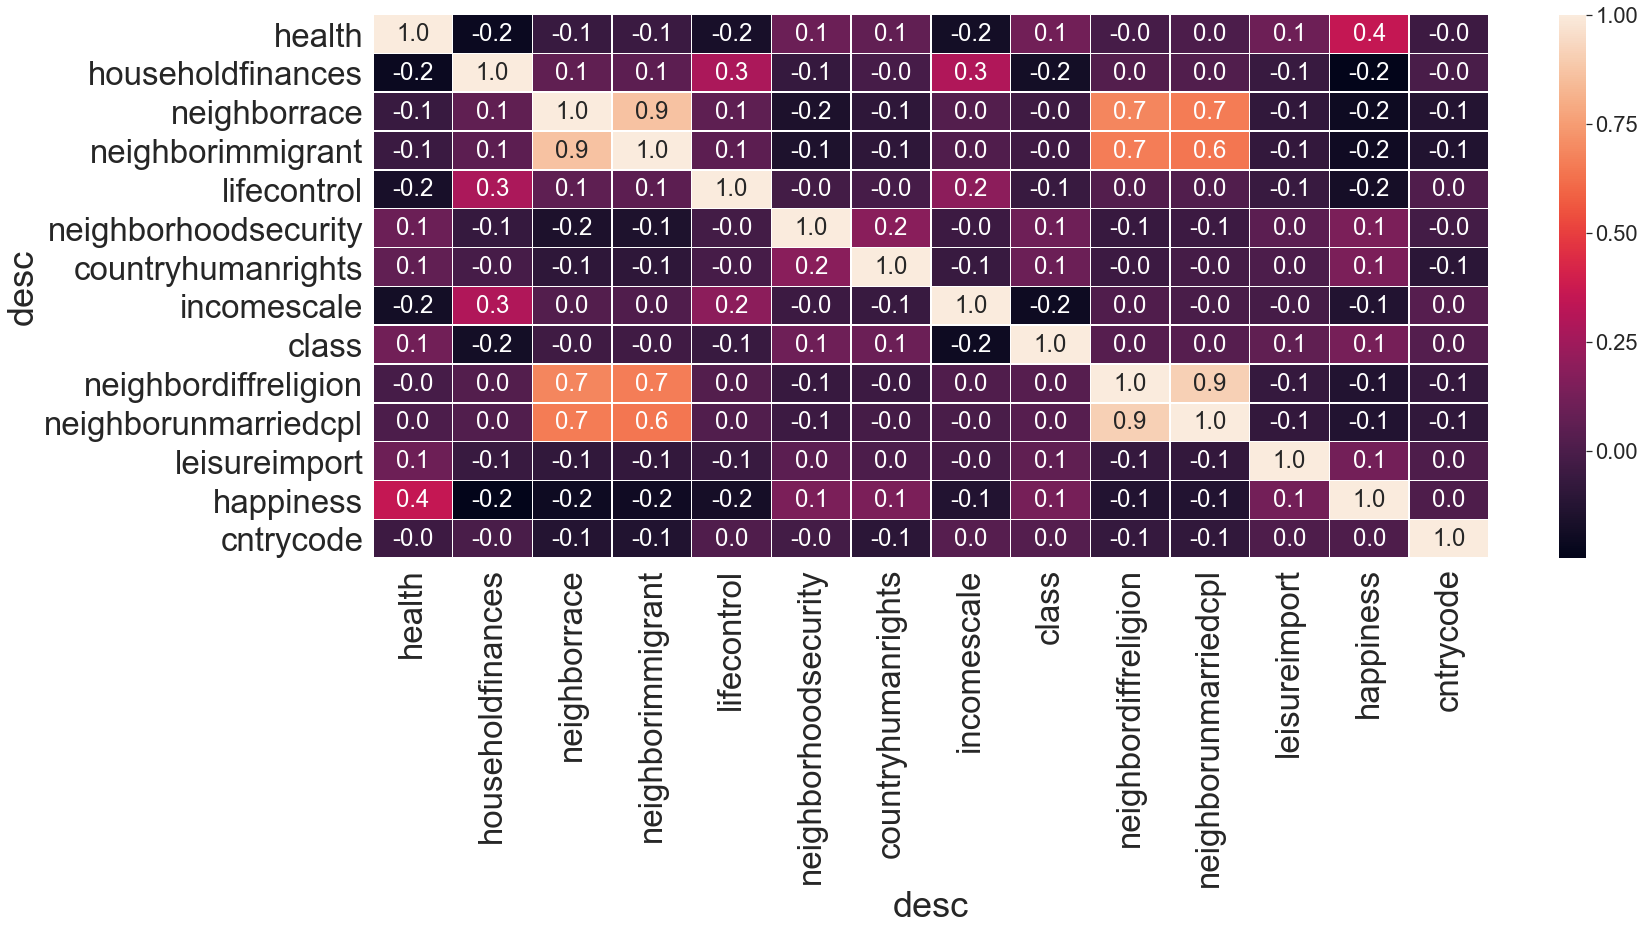

In [10]:
f,ax = plt.subplots(figsize=(25,10))
sns.set(font_scale=2,style="white")
sns.heatmap(df_trimmed.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

## Removing rows of data with missing fields

In [11]:
df_clean = cleanData(df_trimmed)

------------------------------------------------------------------
Removing errant and missing survey responses...
...There are now 73097 rows of data remaining.


## Load country data and join to survey data

In [13]:
df_countries = pd.read_csv('data/country_list.csv', header=None,encoding='latin-1')
df_countries.columns = ['countryname','abbr2','abbr3','cntrycode','lat','lng']
df_countries = df_countries[['countryname','abbr3','cntrycode']]

gdf = gpd.read_file("country_shapefiles/ne_10m_admin_0_countries_lakes.shp")
gdf = gdf.query('TYPE=="Country" or TYPE=="Sovereign country" ')
gdf = gdf.rename(columns = {'ADM0_A3':'abbr3'})
gdf = gdf[['abbr3','geometry','ECONOMY','INCOME_GRP']] 
gdf["ECONOMY"] = (gdf.ECONOMY.astype(str).str[0]).astype(int) # take the first number
gdf["INCOME_GRP"] = (gdf.INCOME_GRP.astype(str).str[0]).astype(int) # take the first number

gdf = pd.merge(gdf,df_countries)
df_all = pd.merge(df_clean,gdf)

## Breakdown of happiness survey responses per country

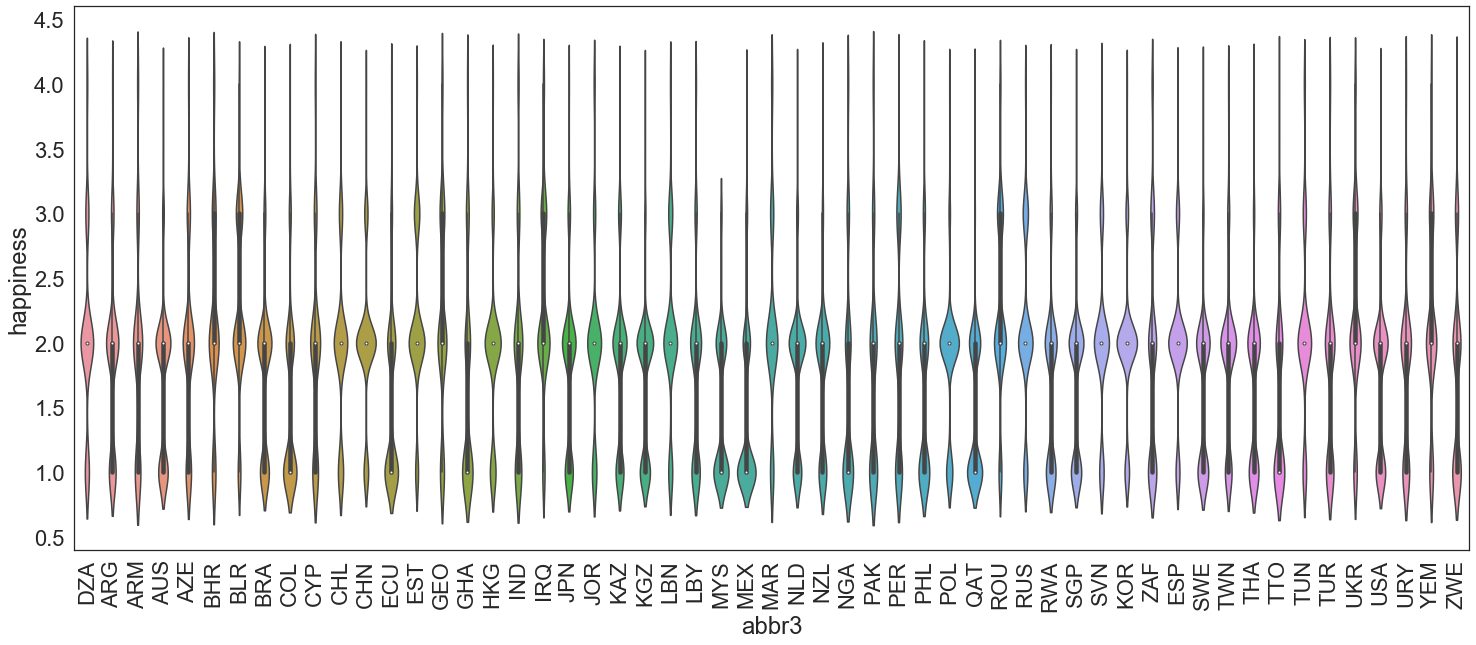

In [14]:
f, axes = plt.subplots(1, 1, figsize=(25, 10))
sns.set(font_scale=2,style="white")
sns.violinplot(x="abbr3", y="happiness", data=df_all, alpha=.7)
plt.xticks(rotation='vertical')
plt.show()

## Average happiness level per country

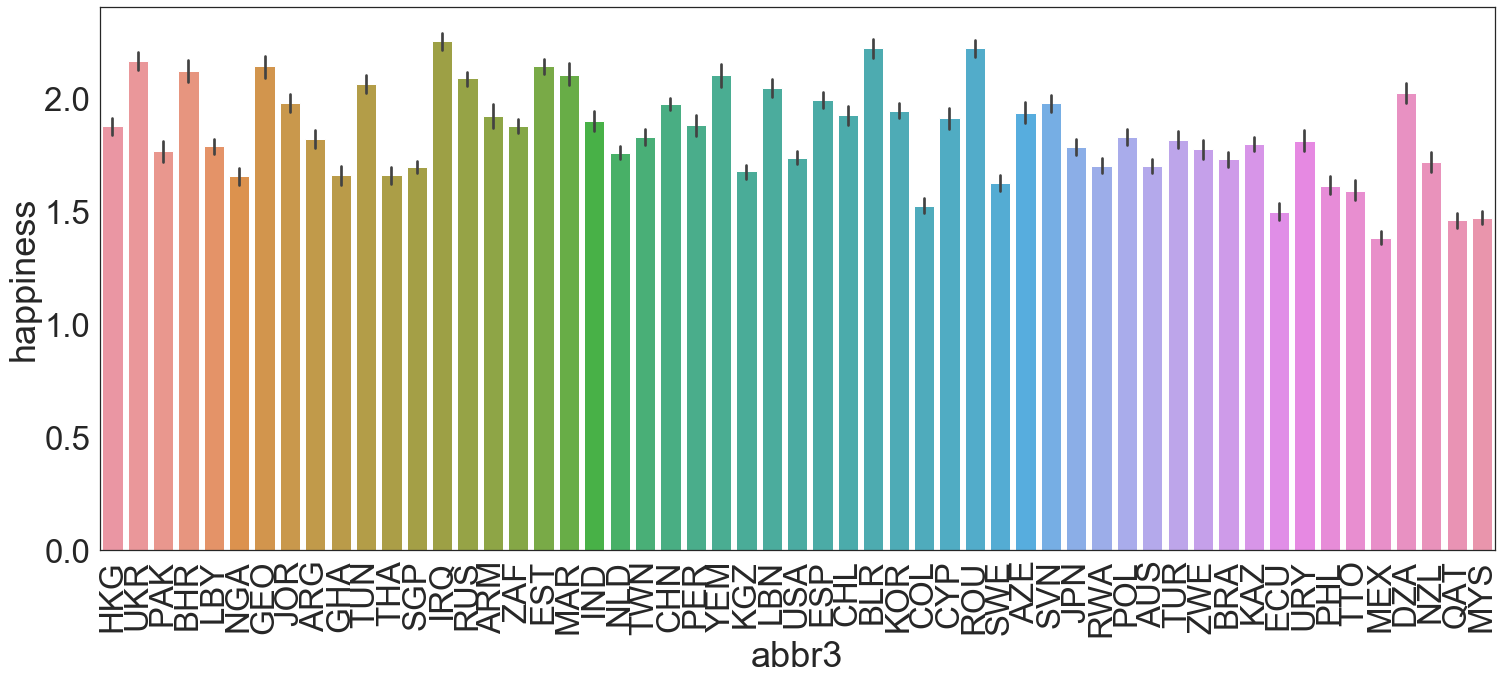

In [62]:
f, axes = plt.subplots(1, 1, figsize=(25, 10))
sns.set(font_scale=2,style="white")
sns.barplot(x='abbr3', y='happiness', data=df4.sort_values('happiness',ascending=False))
plt.xticks(rotation='vertical')
plt.show()

## Most people say they are happy

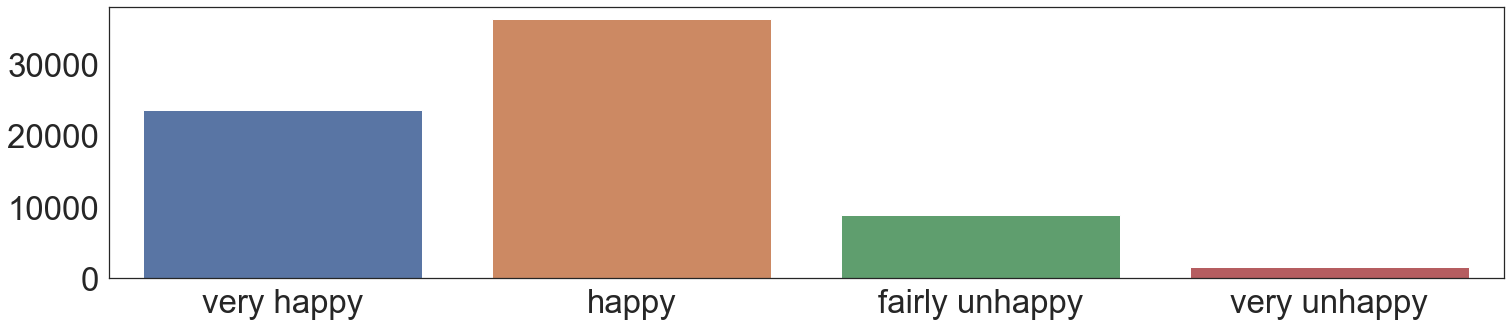

In [93]:
f, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.set(font_scale=3,style="white")
x = df_all.happiness.value_counts().sort_index()
sns.barplot(['very happy','happy','fairly unhappy','very unhappy'],x.values)
plt.show()

## Strong correlation between happiness and health

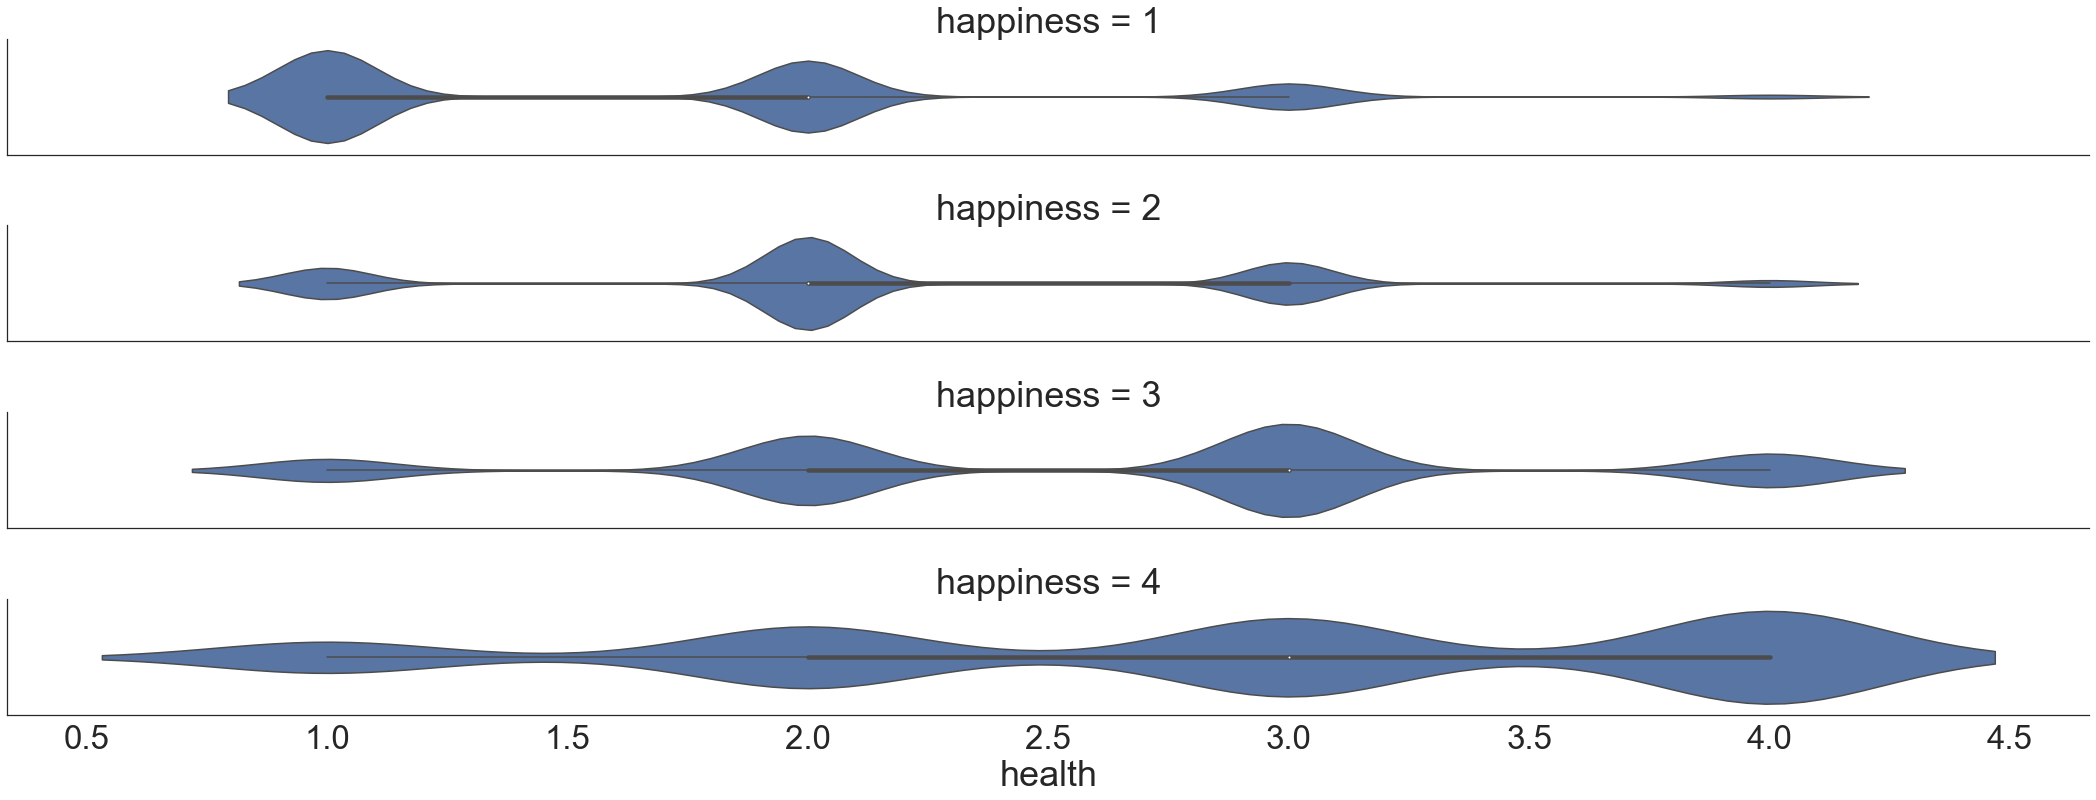

In [61]:
sns.set(font_scale=3,style="white")
g = sns.FacetGrid(df_all, row="happiness", row_order=[1,2,3,4], height=3, aspect=10)
g.map(sns.violinplot, "health", hist=True, rug=True);

## Split data into training and testing datasets

In [68]:
tr,te = splitData(df_all)
print ('The number of unique countries in clean set is {}.'.format( df_all['cntrycode'].unique().shape[0]))
print ('...in train set is {}.'.format(tr['cntrycode'].unique().shape[0]))
print ('...in test set is {}.'.format(te['cntrycode'].unique().shape[0]))

------------------------------------------------------------------
Splitting data into test and train sets...
...There are 56233 rows of train data.
...There are 14058 rows of test data.
The number of unique countries in clean set is 55.
...in train set is 55.
...in test set is 55.


## Set up model for training

In [69]:
feat_tr, feat_te, tar_tr, tar_te = featuresTarget(tr,te)
clf = createModel()

------------------------------------------------------------------
Separating the features and target...
------------------------------------------------------------------
Training a predictive model...


## Dump the created model to a pickle file

In [70]:
pkl_filename = 'classifier.pkl'
model_pkl = open(pkl_filename, 'wb') # Open the file to save as pkl file
pickle.dump(clf, model_pkl)
model_pkl.close() # Close the pickle instances

## Make predictions on the test dataset

In [71]:
predictions = makePredictions(clf, feat_te)
te['predictions'] = predictions

------------------------------------------------------------------
Making predictions...


## Cross-Validate predictions with actual

In [72]:
scores = getCV(predictions,tar_te.values)

------------------------------------------------------------------
Cross-validating the predictions with training data targets...
The RMSE is 0.75.
The prediction accuracy is 58.24%.


## Group invididual data per country

In [88]:
tr_avg_cntry_hap = groupCountries(tr)
te_avg_cntry_hap = groupCountries(te)
avg_cntry_hap = groupCountries(df_all)

------------------------------------------------------------------
Grouping surveys into country groups...
------------------------------------------------------------------
Grouping surveys into country groups...
------------------------------------------------------------------
Grouping surveys into country groups...


## Comparing map of actual vs predicted happiness per country

In [89]:
df1 = te_avg_cntry_hap
df1.reset_index(level=0, inplace=True)
df2 = pd.merge(gdf, df1, on='abbr3', how='left')
df3 = df2[df2.happiness.isnull()==False]
df3[["countryname","happiness","predictions"]].sort_values('happiness')

,countryname,happiness,predictions
118,Mexico,1.429648,1.376884
151,Qatar,1.467005,1.380711
130,Malaysia,1.495868,1.599174
51,Ecuador,1.524000,1.580000
38,Colombia,1.540816,1.571429
180,Trinidad and Tobago,1.609890,1.648352
144,Philippines,1.636752,1.521368
133,Nigeria,1.659026,1.478510
175,Thailand,1.668246,1.597156
189,United States,1.676259,1.707434


### Map of ACTUAL happiness levels on test data set

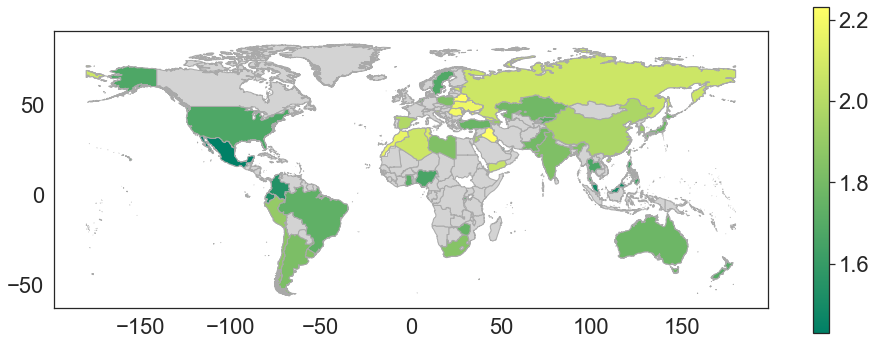

In [75]:
fig, ax = plt.subplots(figsize=(16, 6))
mpl.style.use('seaborn-white')
sns.set(font_scale=2,style="white")
ax.set_aspect('equal')
df2.plot(color='lightgrey',ax=ax,edgecolor='darkgrey')
df3.plot(cmap='summer',column='happiness',ax=ax,legend=True,edgecolor='darkgrey')
plt.show();

### Map of PREDICTED happiness levels on test data set

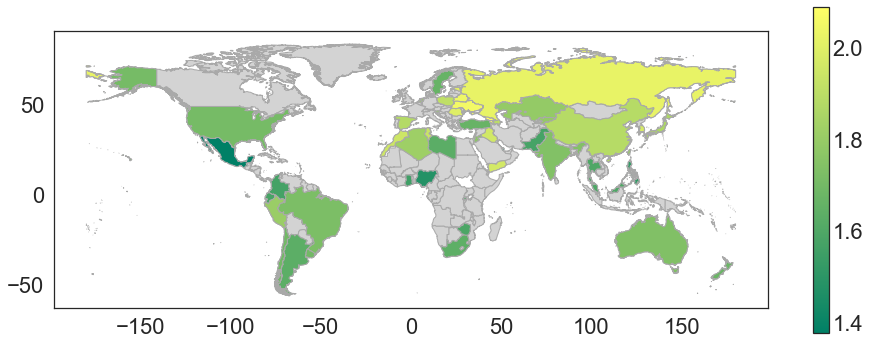

In [76]:
fig, ax = plt.subplots(figsize=(16, 6))
mpl.style.use('seaborn-white')
ax.set_aspect('equal')
df2.plot(color='lightgrey',ax=ax,edgecolor='darkgrey')
df3.plot(cmap='summer',column='predictions',ax=ax,legend=True,edgecolor='darkgrey')
plt.show();

In [101]:
avg_cntry_hap.columns

Index(['health', 'householdfinances', 'neighborrace', 'neighborimmigrant',
       'lifecontrol', 'neighborhoodsecurity', 'countryhumanrights',
       'incomescale', 'class', 'neighbordiffreligion', 'neighborunmarriedcpl',
       'leisureimport', 'happiness', 'cntrycode', 'ECONOMY', 'INCOME_GRP'],
      dtype='object')

In [102]:
gdf.columns

Index(['abbr3', 'geometry', 'ECONOMY', 'INCOME_GRP', 'countryname',
       'cntrycode'],
      dtype='object')

In [104]:
gdf1 = pd.merge(avg_cntry_hap,gdf,on='cntrycode', how='left')

In [105]:
gdf1.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf_all = gpd.GeoDataFrame(gdf1, geometry='geometry')
gdf_all.to_file('happiness.geojson', driver='GeoJSON')